# Assignment 01 - Pitfalls in Data Mining     
## CSCI E-96

The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences.   

In this assignment you will gain a bit of experience with three important concepts in data mining:  

1. **False Discovery Rate Control:** The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences. A related problem is cutting off a large-scale analysis when a desired relationship is 'found'. This practice of **p-value mining** often leads to unwarranted inferences. You will apply false discovery rate (FDR) control methods to address this problem.   
2. **Key-Value Pairs:** Large scale data is typically managed using key-value (KV) pairs. The exercises in this assignment give you some experience working with KV pair data management.  
3. **Map and Reduce Processes:** Much of large scale data mining requires use of a split-apply-combine approach. The data is split into manageable chunks, analytic transformations are applied, and the result combined or aggregated. A commonly used class of a split-apply-combine algorithm is MapReduce. 

In order to keep the scope of this assignment manageable, you will use limited versions of KV pair management and MapReduce. Specifically, you will use common Python tools to implement these concepts rather than dedicated large scale analytic platforms. 

## Multiple Hypothesis Tesing

Testing multiple hypothesis in high-dimensional data can be problematic. Exhaustively testing all pairwise relationships between variables in a data set is a commonly used, but generally misleading from of **multiple comparisons**. The chance of finding false significance, using such a **data dredging** approach, can be surprisingly high. 

In this exercise you will perform multiple comparisons on only 20 **identically distributed independent (iid)** variables. Ideally, such tests should not find significant relationships, but the actual result is quite different. 

To get started, execute the code in the cell below to load the required packages. 

In [2]:
import pandas as pd
import numpy as np
import numpy.random as nr
from scipy.stats import ttest_ind, f_oneway
from itertools import product, combinations
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest as smt

pd.set_option("display.max_rows", None, "display.max_columns", None)

In this exercise you will apply a t-test to all pairwise combinations of identical Normally distributed variables. In this case, we will create a data set with 20 iid Normal distributions of 1000 samples each. Execute the code in the cell below to find this data and display the mean and variance of each variable.  

In [192]:


ncolumns = 20
nr.seed(234)
normal_vars = nr.normal(size=(1000,ncolumns))
print('The means of the columns are\n', np.mean(normal_vars, axis = 0))
print('\nThe variances of the columns are\n', np.var(normal_vars, axis = 0))

The means of the columns are
 [-1.16191649e-01  2.80829317e-02 -1.78516419e-02 -1.44691489e-02
  3.03718152e-02  1.20007442e-02 -9.58845606e-05  1.98662580e-03
  4.94154934e-02 -4.11640866e-02 -6.32977862e-03 -5.93868192e-02
 -2.56373595e-02  1.43568791e-02 -1.44725765e-02 -1.37023955e-02
  1.80622439e-02  5.87029691e-02 -2.02650514e-02 -1.56346106e-02]

The variances of the columns are
 [0.94834508 1.04744241 1.0258018  0.96977571 1.0089001  1.04113864
 1.00657222 0.99192594 1.04713487 1.04329434 1.04023108 0.96791346
 1.03706907 1.07179865 1.01431404 1.05060289 1.02054329 0.9686211
 1.02810287 0.99521555]


Notice that means and variances are close to 0.0 and 1.0 respectively. As expected, there is not much difference between these variables.

How many of these t-tests will show **significance** at the 0.05 cut-off level? There are 380 pairwise combinations, so we expect to find a number of falsely significant test results at this level. To find out, complete and execute the code in the cell below to filter the test results and print those that show significance. 

### Creating a hash 

The goal of this exercise is to compute pairwise hypothesis tests of the differences in means for each of the iid Normal vectors. As an intermediate step you will create a Pandas data frame using a hash of the keys of the vectors. The data frame will contain the **key-value**, $(K,V)$, pairs. Each key must represent an index for the two vectors used to compute the test statistic. The keys will then be used to index the results of these hypothesis tests. 

The question is, how can we create a hash from the keys for the pair of vectors? In this case to we will use a simple, but far from optimal hash. For the two vector indicies $i, j$, for some key and modulo, $m$, we will compute the hash as:  

$$h(i,j) = (i + key*j) mod m$$

> **Computational Note:** The Pandas data frame is an efficient and reasonably scalable **hash table**. The hash function used depends on the type of the key; integer, string, etc. The resulting dictionary of key-value pairs, $(K,V)$, can therefore be access in far less than linear time, often about $O(log(N))$.  

If you are not familiar with Python dictionaries you can find a short tutorial [here](https://www.tutorialspoint.com/python_data_structure/python_hash_table.htm), as well as many other places on the web.

> **Exercise 1-1:** Given that our space of vectors is actually quite small, just 20, we do not need a sophisticated and scalable hash function. This hashed key will then be used to store and retrieve the values using a Python dictionary, in about $O(log(N))$ time.     

> In this exercise you will test a simple hash function and its inverse. Examine the code below and notice that the hash function encodes the two indexes into a single integer by simple additional and multiplication. The modulo operation limits the size of the hash table. However, to keep things simple you will not need to implement any hash collision resolution mechanism. As a result, the size of the table is set much larger than required.  

> To test this hash, do the following:    
> 1. Create a function called hash function to compute the hash. The arguments to the function are $i$ and $j$, the `hash\_key` and the `modulo\_multiplier`. The defaults of the arguments are $hash\_key=1024$ and $modulo\_multiplier=32$. The modulo number is $hash\_key * modulo\_multiplier$, e.g. $modulo = 32,768$. The multiplier is the ratio of expected values stored, $n$, to the number of unique hash keys, $m$, e.g. the ratio $m/n$.
> 2. Using the Python [ittertools.combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) function create all unique pairwise combinations of indexes i and j. The arguments to this function are the indexes to the iid Normal vectors. The iterator is `range(ncolumns)` choose 2, since these comparisons are pairwise.    
> 3. Within this loop call the hash with the values of $i$ and $j$ as arguments.   
> 3. On a single line print the following; the values of i and j, the hash key value, but only if $i \le 6$. The restriction is to keep the printed output shorter.   

In [209]:
def hash_function(i, j, hash_key=1024, modulo_multiplier=32):
    ## Put your code below. 
    ## Simple function is returned
    ##returns ((i + hash_key) * j) % modulo_multiplier
    return  ((i + hash_key) * j) % (hash_key*modulo_multiplier)

count =0
hash = {}
harr =  []

for i,j in combinations(range(ncolumns), 2):
    #if i <= 6: 
        
    #    print( ' Count = ' + str(count))
    hash[(i,j)] =     hash_function(i,j)
    harr.append( hash_function(i,j))

        ##print('i = ' + str(i) + '  j = ' + str(j) + '   hash = ' + str(hash) + '     Count hash = ' + str(count+1))
    count += 1
    combCount = 1
        
for i,j in combinations(range(ncolumns),2):     
    if i<= 6:
        print('COUNT: '+ str(combCount) + ':  hash[(' + str(i)+ ' , '+ str( j) + ')] : ' + str(hash[i,j]))
    combCount += 1
        
    



COUNT: 1:  hash[(0 , 1)] : 1024
COUNT: 2:  hash[(0 , 2)] : 2048
COUNT: 3:  hash[(0 , 3)] : 3072
COUNT: 4:  hash[(0 , 4)] : 4096
COUNT: 5:  hash[(0 , 5)] : 5120
COUNT: 6:  hash[(0 , 6)] : 6144
COUNT: 7:  hash[(0 , 7)] : 7168
COUNT: 8:  hash[(0 , 8)] : 8192
COUNT: 9:  hash[(0 , 9)] : 9216
COUNT: 10:  hash[(0 , 10)] : 10240
COUNT: 11:  hash[(0 , 11)] : 11264
COUNT: 12:  hash[(0 , 12)] : 12288
COUNT: 13:  hash[(0 , 13)] : 13312
COUNT: 14:  hash[(0 , 14)] : 14336
COUNT: 15:  hash[(0 , 15)] : 15360
COUNT: 16:  hash[(0 , 16)] : 16384
COUNT: 17:  hash[(0 , 17)] : 17408
COUNT: 18:  hash[(0 , 18)] : 18432
COUNT: 19:  hash[(0 , 19)] : 19456
COUNT: 20:  hash[(1 , 2)] : 2050
COUNT: 21:  hash[(1 , 3)] : 3075
COUNT: 22:  hash[(1 , 4)] : 4100
COUNT: 23:  hash[(1 , 5)] : 5125
COUNT: 24:  hash[(1 , 6)] : 6150
COUNT: 25:  hash[(1 , 7)] : 7175
COUNT: 26:  hash[(1 , 8)] : 8200
COUNT: 27:  hash[(1 , 9)] : 9225
COUNT: 28:  hash[(1 , 10)] : 10250
COUNT: 29:  hash[(1 , 11)] : 11275
COUNT: 30:  hash[(1 , 12)] :

> Examine the key pairs and the hash values. The question is, are there any hash collisions? This can be done as follows:   
ANSWER: No there are not. I checked the Reoccurrances of each hash value and they were 1
> 5. Compute a list of the hash values for all combinations of $i$ and $j$. 
ANSWER: Shown in the above cell
     with hash[(i,j)] : hash value listed for each count
> 6. Print the length of the list.  
> 7. Print the length of the unique values of the hash. You can find the unique values in a list with the [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function. 

In [211]:
## Put your code below. 

Count1 = 0
# using the function np.unique we create a array with only unique values on the Hash function value
ui, harr_u = np.unique(harr,return_counts = True)

#for uindex in range(len(harr_u)):
#    Count1 += 1
#    print('harr_unique(' + str(uindex) + '): ' + str(ui[uindex]) + ' Reoccurrances: '+ str(harr_u[uindex]))
print(' The Length of the list is: '+ str(len(harr)))
print(' The Total Number of unique instances is: '+ str(len(harr_u)))

##print(ui)

 The Length of the list is: 190
 The Total Number of unique instances is: 190


> Examine the results you have printed. Is there any evidence of hash key collisions?     
> The ratio of $m/n$ is deliberately kept high since the simple hash function has no collision resolution mechanism. Optionally, you can try reducing this ration (the multiplier) to 16 and 8, noting the increase in hash collisions.  
> **End of exercise.**

ANSWER: The length of the list is 190/ The Total number of unique instatnces is 190.
So there are no evidence of hash collisions in this case.

No: There is no evidence of hash key collisions. There are 190 Combinations with 190 unique values. Each reoccurance has been determined for the unique hash values indicating the number of collisions.

### The map process

We are constructing this example a map and a reduce process. The processes are intended to compute the hypothesis test for differences of means between all the pairs of vectors. The first step is the map process, which creates the keys, or values of $i$ and $j$ for these pairs.   

> **Exercise 1-2:** You will now create the code for the map task which build a data frame with $i, j$ key pairs indexed by the hash. By the following steps you will create code that represents a map task.  
> 1. Create a data frame with two columns $i$ and $j$ with rows $= hash_key * modulo_multiplier $ and set all values to $= numpy.nan$.
> 2. Create a loop over all combinations of the pairs of i and j.   Done
> 3. Compute the hash key value for the indexes, i and j. 
> 4. Add the $i$ and $j$ values to the row indexed by the hash key.  
> 5. Return the hash table. ANSWER: used the hash function as the index
> 6. Execute the function to create the hash table.  
> 7. Compute and print the length of the hash table. 

In [233]:
def map_hypothesis(vars, hash_key=1024, modulo_multiplier=32):

# clean up

    arr = [[], []]
    arr_vals = []
    hash_arr = []
    arr = [[0,0],
           [0,1],
           [1,0],
           [1,1],
           [1,2]]
    lenrow = len(arr)
    lencol = len(arr[0])
    ind = 0

    ## make the index or rows
    ##creates a data frame 'blank'
    df = pd.DataFrame(arr)
    
    ##1. Creates two columns i, j
    df.columns = ['i','j']

    # declarations
    ncols = vars.shape[1]
    ncols1 = len(vars[0])
    j_val = []
    hash_val = []
    ncolumns = ncols
    #print('ncols-shape :' + str(ncols) + ' ncols1-len(vars[0]) :' + str(ncols1))

    ## J goes from 0 to 19
    ind = 0
    #2. loops over all combinations of i, j for ncols length=20 in pairs of 2
    for i,j in combinations(range(ncols), 2):
        
        ind += 1
    #3. using the function hash_function(i,j) it computes the hash for given function    
        hash[(i,j)] = hash_function(i,j)
        hash_arr.append(hash_function(i,j))
        hash_val.append( hash[(i,j)])
    #4. This newRow will add the cols i,j when the arr_vals are assigned all at once
        newRow = (i,j,hash[i,j])
        arr_vals.append(newRow)

    df_arr = pd.DataFrame(arr_vals)
   
    df_arr.columns = ['i','j', 'hash']
    df_arr.loc[:,'hash'] = pd.DataFrame(hash_val)
    combCount = 1
    df_arr.index = hash_arr
    print('DF_ARR')
    print(df_arr.head())
    #5. returns the hash table
    return df_arr 
 

#6. Execute the function to create the hash table.
hash_table = map_hypothesis(normal_vars)
#7. Compute and print the length of the hash table.
print('Length of Hash Table is: '+ str(len(hash_table)))

DF_ARR
      i  j  hash
1024  0  1  1024
2048  0  2  2048
3072  0  3  3072
4096  0  4  4096
5120  0  5  5120
Length of Hash Table is: 190


> **End of exercise.**

### The shuffle and reduce task

Now that you have the keys for the pairwise combinations of the vectors it is time to perform the reduce process. The reduce process computes the pair-wise t-statistics and p-values. These statistical values are indexed by the keys of the pair of vectors. This process reduces the full vectors of values down to just two numbers for each pair of vectors. 

> **Exercise 1-3:** You will now create and apply the following code for the reduce process:   
> 1. Create an empty data frame with columns, `i`, `j`, `t_statistic`, and `p_value`.    
> 2. Using a for loop iterate over all possible (hashed) keys of the data frame. An if statement is used to test if these are valid values of the key, i. Use the [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html) function for this test.  
> 3. Extract the values of i and j from the input data frame. 
> 4. Using keys, compute the t-statistic and p-value using [scipy.stats import ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).
> 5. Append a row to the output data frame.
> 6. Return the data frame, sorted in ascending order, using the [Pandas.DataFrame.sort_values](https://turned.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method and re-indexed using the [Pandas.DataFrame.reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) method.    
> 7. Execute your function and save the returned data frame.

In [247]:
def reduce_significance(hash_table, values):  
    ## Create a data framreturn the results of the 
    ## the reduce process. The results are grouped by the first 
   
    sig_level = 0.05
    ncols = hash_table.shape[1]
    nrows = hash_table.shape[0]
 
    tt =ttest_ind(normal_vars[:,0], nr.normal(loc = 0.01, size=(1000,1)))
    #1.Create an empty data frame with columns, i, j, t_statistic, and p_value.
    #1a. I created an empty dataframe with i, j. so that t_statisticc and p_value
    #    would be added later in a mass assignment
    test_results = pd.DataFrame(columns=['i','j'])
 
    count2 = 0
    extract_i = []
    extract_j = []
    i_arr = []
    j_arr = []
    data = []
    hash_arr  = []
    hash_a = []
    tt_arr = []
    pv_arr = []
    sig_arr = []
    sig_count = 0

    # 2. Used a for loop to iterate over all possible hashed keys of DataFrame hash_table
    # Looping over all possible keys of the hash_table
    for hash_num in range(hash_table.shape[0]): 
        if not np.isnan(hash_table.iloc[hash_num,0]):
            # This is where you lookup in the hash table at super fast speeds
            # 3. Extract the values of i and j from the input data frame
            ival = hash_table.iloc[hash_num,0]
            #
            jval = hash_table.iloc[hash_num,1]
            #
            # 4. Using keys, compute the t-statistic and p-value using scipy.stats import ttest_ind.
            tt = ttest_ind(values[:,ival] , values[:,jval]).statistic
            #print(tt)
            #print(str(len(tt)))
            pv = ttest_ind(values[:,ival] , values[:,jval]).pvalue
            
            i_arr.append(values[:,ival])
            j_arr.append(values[:,jval])
            tt_arr.append(tt)
            pv_arr.append(pv)
            #sig_arr.append('SIG')
            if (pv <= sig_level):
                sig_arr.append('SIG')
                sig_count += 1
            else:
                sig_arr.append('Not-Sig')
            
            #5. Append a row to the output data frame
            data.append((ival,jval,hash_function(ival,jval)))
    
    

    
    print('len(hash_table): ' + str(len(hash_table)) )  
   
    #print('len(test_results): ' + str(len(test_results)) ) 
    print('len(tt_arr): '+ str(len(tt_arr)))
    print('len(pv_arr): '+ str(len(pv_arr)))
    print('len(sig_arr): '+ str(len(sig_arr)))
    print('Sig-Count: ' + str(sig_count))
    test_results = pd.DataFrame(data)
    test_results.columns=['i','j','hash']
    test_results.loc[:,'t_statistic'] = tt_arr
    test_results.loc[:,'p_value'] = pv_arr
    test_results.loc[:,'sig'] = sig_arr
    #print('PRINT TEST_RESULTS')
    #print(test_results.head())

    #6.Return the data frame, sorted in ascending order, usin
    return test_results.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)        
        
#7. Execute your function and save the returned data frame
test_stats = reduce_significance(hash_table, normal_vars)
test_stats.to_csv("test_stats.csv")


len(hash_table): 190
len(tt_arr): 190
len(pv_arr): 190
len(sig_arr): 190
Sig-Count: 22


> 8. In the cell below, create a filter for pair test cases which are significant and save these cases in a data frame. 
> 9. Print the number (len) of significant results.
> 10. Print the rows with the significant test results.

In [248]:
significance_level = 0.05
test_stats = reduce_significance(hash_table, normal_vars) 
## Put your code below. 
#print(test_stats)
#8. In the cell below, create a filter for pair test cases
#   which are significant and save these cases in a data frame.
sig_filter_arr = test_stats.loc[test_stats['sig']=='SIG']

df_sig = pd.DataFrame(sig_filter_arr)
#print('The dataframe with Significant Results are as Follows:')
#print(df_sig)
# print(test_stats.head(10))

print('9. The length of the Significant Results are: ' + str(test_stats.loc[test_stats['sig']=='SIG'].shape[0]))


print('10. The Significant Test Results are as Follows:')
print(test_stats.loc[test_stats['sig']=='SIG'])



len(hash_table): 190
len(tt_arr): 190
len(pv_arr): 190
len(sig_arr): 190
Sig-Count: 22
9. The length of the Significant Results are: 22
10. The Significant Test Results are as Follows:
     i   j   hash  t_statistic   p_value  sig
0    0  17  17408    -3.992565  0.000068  SIG
1    0   8   8192    -3.705426  0.000217  SIG
2    0   4   4096    -3.311203  0.000946  SIG
3    0   1   1024    -3.227865  0.001267  SIG
4    0  16  16384    -3.024120  0.002525  SIG
5    0  13  13312    -2.903111  0.003735  SIG
6    0   5   5120    -2.872598  0.004114  SIG
7   11  17  17595    -2.682146  0.007375  SIG
8    0   7   7168    -2.681570  0.007388  SIG
9    0   6   6144    -2.624430  0.008746  SIG
10   0  10  10240    -2.462400  0.013885  SIG
11   8  11  11352     2.422580  0.015499  SIG
12   0   3   3072    -2.321463  0.020362  SIG
13   0  14  14336    -2.294894  0.021842  SIG
14   0  15  15360    -2.291186  0.022056  SIG
15   0  19  19456    -2.279797  0.022725  SIG
16   9  17  17561    -2.225359  0

> Notice the large number of apparently significant tests. Answer the following questions:  
> 1. Is the number of false positive cases higher than expected? 
ANSWER 1. 22/190 = 0.11578.  Yes this is > our normal 5% acceptable cutoff for significance level
> 2. Examine which of the iid Normal vectors contribute to the false positive results. Are there vectors which contribute multiple times? 
ANSWER 2. It looks like Column 0 is a high contributor to the false positive cases
> **End of exercise.**

Yes. There seems to be an abundant number of possible False Positives. Column vector '0' seems to contribute to alot of these Significant cases.

### Bonferroni correction  

Several adjustments to the multiple comparisons problem have been proposed. In Dunn published a method know as the **Bonferroni correction** in 1961. The Bonferroni correction is a widely used method to reduce the false positive rate of hypothesis tests.  The adjustment is simple:
$$\alpha_b = \frac{\alpha}{m}\\
with\\ 
m =\ number\ of\ groups$$

Can the Bonferroni correction help? Yes, by greatly increasing the confidence level required for a statistically significant result. The problem with the Bonferroni correction is the reduction in power as the  grows smaller. For big data problems with large numbers of groups, this issue can be especially serious. 

**Exercise 1-4:** You will now apply the Bonferroni correction to the iid Normal vectors. To do so, you will compute the Bonferroni threshold and the apply it to the p-values:   

In [256]:
## Exercise 1-4        
## m = number of groups
## alpha = confidence = 0.05

def reduce_significance_bonferroni(hash_table, values,bon_alpha):  
    ## Create a data framreturn the results of the 
    ## the reduce process. The results are grouped by the first 
   
    sig_level = 0.05
    ncols = hash_table.shape[1]
    nrows = hash_table.shape[0]
 
    tt =ttest_ind(normal_vars[:,0], nr.normal(loc = 0.01, size=(1000,1)))
    #1.Create an empty data frame with columns, i, j, t_statistic, and p_value.
    #1a. I created an empty dataframe with i, j. so that t_statisticc and p_value
    #    would be added later in a mass assignment
    test_results = pd.DataFrame(columns=['i','j'])
 
    #Declarations
    count2 = 0
    extract_i = []
    extract_j = []
    i_arr = []
    j_arr = []
    data = []
    hash_arr  = []
    hash_a = []
    tt_arr = []
    pv_arr = []
    sig_arr = []
    sig_count = 0

    # 2. Used a for loop to iterate over all possible hashed keys of DataFrame hash_table
    # Looping over all possible keys of the hash_table
    for hash_num in range(hash_table.shape[0]): 
        if not np.isnan(hash_table.iloc[hash_num,0]):
            # This is where you lookup in the hash table at super fast speeds
            # 3. Extract the values of i and j from the input data frame
            ival = hash_table.iloc[hash_num,0]
            #
            jval = hash_table.iloc[hash_num,1]
            #
            # 4. Using keys, compute the t-statistic and p-value using scipy.stats import ttest_ind.
            tt = ttest_ind(values[:,ival] , values[:,jval]).statistic
            #print(tt)
            #print(str(len(tt)))
            pv = ttest_ind(values[:,ival] , values[:,jval]).pvalue
            
            i_arr.append(values[:,ival])
            j_arr.append(values[:,jval])
            tt_arr.append(tt)
            pv_arr.append(pv)
            #sig_arr.append('SIG')
            if (pv <= bon_alpha):
                sig_arr.append('SIG')
                sig_count += 1
            else:
                sig_arr.append('Not-Sig')
            
            #5. Append a row to the output data frame
            data.append((ival,jval,hash_function(ival,jval)))
    
    

    
    print('len(hash_table): ' + str(len(hash_table)) )  
   
    #print('len(test_results): ' + str(len(test_results)) ) 
    print('len(tt_arr): '+ str(len(tt_arr)))
    print('len(pv_arr): '+ str(len(pv_arr)))
    print('len(sig_arr): '+ str(len(sig_arr)))
    print('Sig-Count: ' + str(sig_count))
    test_results = pd.DataFrame(data)
    test_results.columns=['i','j','hash']
    test_results.loc[:,'t_statistic'] = tt_arr
    test_results.loc[:,'p_value'] = pv_arr
    test_results.loc[:,'sig'] = sig_arr
    #print('PRINT TEST_RESULTS')
    #print(test_results.head())

    print('9. The length of the Significant Results are: ' + str(test_results.loc[test_results['sig']=='SIG'].shape[0]))


    print('10. The Significant Test Results are as Follows:')
    print(test_results.loc[test_results['sig']=='SIG'])

    #6.Return the data frame, sorted in ascending order, usin
    return test_results.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)        
      
       
alpha = .05
m = 20
# Ex 1-4: You will now apply the Bonferroni correction to the iid Normal vectors. To do so, 
#         you will compute the Bonferroni threshold and the apply it to the p-values:
bon_nu_alpha = alpha/m
print('bon_nu_alpha: ' + str(bon_nu_alpha))
bon_test_stats = reduce_significance_bonferroni(hash_table, normal_vars,bon_nu_alpha) 



bon_nu_alpha: 0.0025
len(hash_table): 190
len(tt_arr): 190
len(pv_arr): 190
len(sig_arr): 190
Sig-Count: 4
9. The length of the Significant Results are: 4
10. The Significant Test Results are as Follows:
    i   j   hash  t_statistic   p_value  sig
0   0   1   1024    -3.227865  0.001267  SIG
3   0   4   4096    -3.311203  0.000946  SIG
7   0   8   8192    -3.705426  0.000217  SIG
16  0  17  17408    -3.992565  0.000068  SIG


> Even with the Bonferroni correction we have some false significance tests, if only just barely!    
> **End of exercise.**

But, can we detect small effect with Bonferroni correction, as this method significantly reduces power of tests? Execute the code in the cell below, which compares a standard Normal to a Normal with a small mean (effect size), to find out. 

In [250]:
nr.seed(567)


ttest_ind(normal_vars[:,0], nr.normal(loc = 0.01, size=(1000,1)))

Ttest_indResult(statistic=array([-2.49553488]), pvalue=array([0.01265684]))

Given the Bonferroni correction, this difference in means would not be found significant. This illustrates the downside of the correction, which may prevent detection of significant effects, while still finding false significance. 

## False Discovery Rate Control Methods 

We have seen the potential pitfalls of multiple hypothesis testing. Further, we have seen that a simple approach to **false discovery rate (FDR) control** is not effective. You will now apply more sophisticated FDR control methods to control the FDR. 

Inflammatory bowel disease is an auto immune disease that is characterized by chronic inflammation in the digestive tract. In 2020, there were around 2.5 million people with inflammatory bowel disease in the United States. It is estimated that the prevalence of IBD among U.S. population will rise to around 3.5 million by 2030.There are two forms of IBD: Ulcerative Colitis (UC) and Crohn’s disease (CD). 

The specific problem we will explore is to determine which genes lead to expression of a certain disease. In this example, there are gene expression data for 97 patients. Some of these patients have ulcerative colitis and others have Crohn's disease, which are believed to be genetically inherited.    

One approach to this problem is to perform hypothesis tests on the expression of the genes between patients with the two conditions. Since there are over 10,000 genes there is considerable chance for false discovery. Therefore, careful application of FDR control is required.

To continue with the example, execute the code in the cell below to load the data and print the dimensionality of the data frame. 

In [11]:
gene_data = pd.read_csv('../data/ColonDiseaseGeneData-Cleaned.csv')
print('The Dimensions of gene_data: ' + str(gene_data.shape))

The Dimensions of gene_data: (97, 10498)


There are data from 97 patients for 10,497 genes. A large number of hypothesis tests are required!     

Execute the code in the cell below to view the first 5 columns of the data frame, which includes the expression of the first 4 genes.  

In [12]:
print(gene_data.iloc[:,:5].tail(5 ))
gd_head = pd.DataFrame(gene_data.iloc[:,:5].head())
gd_tail = pd.DataFrame(gene_data.iloc[:,:5].tail(5))
#gd_list = list(gene_data)

#abridgd_gd = pd.concat([gd_head, gd_tail])
print(abridgd_gd)
gene_data.groupby(['Disease State'])

           Disease State  FAM138F  LOC100133331  LOC100132062  LOC388312
92  Crohn's Disease (CD)   7.3420        8.3204        8.5116     8.9684
93  Crohn's Disease (CD)   6.6286        9.7240       10.2898    11.1171
94  Crohn's Disease (CD)   6.7240        9.5739       10.2080    11.0556
95  Crohn's Disease (CD)   7.5894        9.7265       10.3238    11.1514
96  Crohn's Disease (CD)   7.4378        8.8964        9.3807    10.1370
              Disease State  FAM138F  LOC100133331  LOC100132062  LOC388312
0   Ulcerative Colitis (UC)   7.2980        8.5650        8.7778     9.2365
1   Ulcerative Colitis (UC)   8.0751        8.3536        8.7785     9.4256
2   Ulcerative Colitis (UC)   6.8458        8.8254        9.1960     9.8835
3   Ulcerative Colitis (UC)   7.6507        8.1838        8.2845     8.8011
4   Ulcerative Colitis (UC)   7.3524        8.4415        8.6630     9.1292
92     Crohn's Disease (CD)   7.3420        8.3204        8.5116     8.9684
93     Crohn's Disease (CD)   

### Holm's method

You will apply two FDR control methods to these data.These methods attempt to conod trol the FDR while not being overly conservative like the Bonferronic correction. The first of these Holm's method.    

The Holm's method operates on the ordered set of p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$. The threshold for the $ith$ p-value, $p(i) is:  

$$p(i) \le Threshold(Holm's) = \frac{\alpha}{N - i + 1}$$

For example: for the 10th ordered p-value with 1,000 total tests (genes) and significance level of 0.05, the cutoff is:   

$$p(10) \le \frac{0.05}{1000 - 10 + 1} = 0.00005045$$

### Map process  

> **Exercise 01-4:** To start the processing of these data you will first create and execute code for a map process. The map process groups the data by the patient's disease into data frame, ulcerative, crohns. The keys for each of these key-value pairs are the gene identifier. Notice that one key is all that is needed in this case. Now do the following to create and execute a function, `map_gene`:   
> 1. Create a logical mask and group the values by `Disease State` into two data frames.
> 2. Return the transpose of the two data frames, removing the `Disease State` values. The result of this operation should be data frames with gene expressions in the columns and the gene identifier as the row index. 

In [257]:
def map_gene(gene_data):  
    ## First, separate the columns by disease type  
    #1. Create a logical mask and group the values by Disease State into two data frames
    ## Put your code below.
    df_crohns = pd.DataFrame(gene_data)
    #df_ulcerative = pd.DataFrame(gene_data.iloc[:,:])
    df_ulcerative = pd.DataFrame(gene_data)
    c = df_crohns.loc[df_crohns['Disease State']=="Crohn's Disease (CD)"]
    u = df_ulcerative.loc[df_crohns['Disease State']=="Ulcerative Colitis (UC)"]
    
    #2b. removing the Disease State values
    c.drop('Disease State', inplace = True, axis = 1 )
    u.drop('Disease State', inplace = True, axis = 1 )
    
    #2a. Return the transpose of the two data frames
    c_T = c.transpose()
    u_T = u.transpose()
    #print(c_T)
    #print(ulcerative)
    return u_T, c_T
#u = map_gene(gene_data)
#2c.The result of this operation should be data frames with gene expressions in the columns and the gene identifier as the row index.' )
ulcerative, crohns = map_gene(gene_data)    

2c.The result of this operation should be data frames with gene expressions in the columns and the gene identifier as the row index.


C:\Users\lonmc\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


> 3. Execute the code in the cells below to display the heads of these data frames and examine the results. 

In [75]:
ulcerative.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
FAM138F,7.2980,8.0751,6.8458,7.6507,7.3524,7.2811,7.8913,7.0641,7.5266,7.0322,7.0657,7.5924,7.0600,7.1898,7.2143,7.0964,7.2198,7.3403,7.4461,7.3455,7.0880,7.2825,7.1724,6.8806
LOC100133331,8.5650,8.3536,8.8254,8.1838,8.4415,8.4023,8.8026,8.5498,8.8004,8.8119,8.6229,8.5463,8.7177,8.9140,8.5502,8.7591,9.2102,9.4456,8.5284,8.6927,8.2631,8.7345,8.3719,8.5305
LOC100132062,8.7778,8.7785,9.1960,8.2845,8.6630,8.6892,8.6892,8.7145,9.1334,9.1838,8.9592,9.1006,9.0183,9.4450,8.8953,9.2912,9.7642,10.0189,8.7357,9.0602,8.4369,9.1484,8.7555,8.8483
LOC388312,9.2365,9.4256,9.8835,8.8011,9.1292,9.3487,8.4706,9.0538,9.8241,9.8496,9.5281,9.7927,9.6008,10.1850,9.5342,9.9657,10.5014,10.7591,9.2506,9.7192,8.8794,9.7872,9.4038,9.3340
BC016143,7.3570,7.4431,7.5415,7.7199,7.4482,7.4577,8.6198,7.9258,7.4278,7.8487,7.3141,7.3871,7.5602,7.3844,7.2356,8.1990,7.4642,7.4081,7.7304,7.5309,7.9830,7.9588,7.5957,7.4893


In [71]:
crohns.head()

,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
FAM138F,7.2068,7.8298,7.2091,7.0550,7.1302,7.5896,7.1414,7.5786,7.3579,7.2707,8.0351,7.5432,7.1810,7.5264,7.3716,7.4850,7.4165,6.9773,7.8786,7.5083,7.0880,6.8838,6.8119,7.2496,6.8267,7.0636,7.6835,7.2210,6.8487,7.5918,7.1678,7.3017,7.1610,7.2261,7.1593,7.1019,7.3116,7.8494,7.2701,7.5647,7.2515,7.1507,7.4678,7.5946,7.4190,7.1283,7.1075,7.5319,7.4337,6.8102,6.7455,7.4960,7.2845,7.0643,7.3322,7.2334,7.1355,7.3307,7.3263,7.5301,7.2411,7.7174,7.8088,6.8142,7.0029,7.1317,7.2842,7.0717,7.3420,6.6286,6.7240,7.5894,7.4378
LOC100133331,8.7216,8.9175,8.9301,8.5439,8.4071,8.6109,8.5179,8.5027,8.4111,8.4076,8.0996,8.3209,8.2516,8.7270,8.4931,8.3430,8.2109,8.3712,8.1959,8.5155,8.4385,8.4538,8.3748,8.9122,8.9778,9.4644,9.3493,8.7814,8.8734,8.2312,8.1288,9.2388,9.7806,9.3428,9.3831,8.3430,8.4065,8.3663,8.4757,8.8474,8.6235,8.8505,8.3267,8.6988,8.4272,8.6103,8.6806,8.8390,8.1981,8.4159,8.4007,9.1633,8.9434,8.2883,8.6903,8.4386,8.1473,8.6789,8.6000,8.5545,8.5200,8.6790,8.7493,9.1015,8.8982,8.5958,8.9521,8.7461,8.3204,9.7240,9.5739,9.7265,8.8964
LOC100132062,8.9883,9.1842,9.2968,8.8213,8.6142,8.8517,8.7155,8.6525,8.6590,8.8388,8.1967,8.6573,8.4162,9.0187,8.7526,8.5856,8.3940,8.7869,8.5050,8.7980,8.8253,8.7470,8.5175,9.4422,9.3882,10.0785,9.8959,9.1714,9.2340,8.5544,8.3662,9.7731,10.4121,9.8967,9.8278,8.5420,8.4365,8.7258,8.8142,9.1067,8.8586,9.3616,8.4853,9.0260,8.7151,9.0461,9.0847,9.2998,8.4922,8.7216,8.6120,9.4830,9.1429,8.6007,9.0542,8.6074,8.4648,9.1033,8.7555,8.6041,8.9117,8.9892,8.9242,9.6005,9.1675,8.9374,9.2933,9.1679,8.5116,10.2898,10.2080,10.3238,9.3807
LOC388312,9.4779,9.6337,9.8979,9.4340,9.0457,9.3895,9.1508,8.9109,9.1606,9.4837,8.6139,9.2815,8.9155,9.5883,9.2896,9.1303,8.8056,9.4372,9.0982,9.3524,9.4505,9.2828,8.9693,10.1554,10.0778,10.8549,10.6338,9.8162,9.8769,9.1008,8.9679,10.5605,11.2396,10.6759,10.5998,8.9747,8.6799,9.3271,9.3429,9.6523,9.3837,10.0741,8.8199,9.5730,9.3093,9.6250,9.6714,9.9908,9.0470,9.2068,9.0240,10.0791,9.6071,9.1311,9.6266,9.0808,9.0846,9.6172,9.1330,8.8550,9.4735,9.5009,9.2937,10.3573,9.7203,9.6554,9.8822,9.7870,8.9684,11.1171,11.0556,11.1514,10.1370


### Reduce process 

> **Exercise 01-5:** With the key-value pairs organized by disease state, it is time to create and execute code of a reduce process. The reduce process will compute the pairwise t-statistics and p-values for each gene and return the sorted results. Specifically, your `gene_test` with arguments of the two mapped data frames will do the following:   
> 1. Create an empty data frame with columns gene, t_statistics, and p-value.
> 2. A for loop iterates over the keys of either of the data frames.  
> 3. Compute the t-statistic and p-value for the gene (key).
> 4. Append the results to the data frame.   
> 5. Sort the results data frame, inplace, into ascending order.
> 6. Return the resulting data frame.

In [262]:
def gene_test(ulcerative, crohns):  

    ## Put your code below. 
    tt_add = []
    gene_arr = np.array(crohns.index)
    
    #2. A for loop iterates over the keys of either of the data frames.
    for dis_key in crohns.index:
        #3.Compute the t-statistic and p-value for the gene (key).
        tt1 = ttest_ind(ulcerative.loc[dis_key,:] ,crohns.loc[dis_key,:]).statistic

        pv1 = ttest_ind(ulcerative.loc[dis_key,:] ,crohns.loc[dis_key,:]).pvalue
        #4. Append the results to the data frame
        tt_add.append([dis_key,tt1,pv1])
    #1. Create an empty data frame with columns gene, t_statistics, and p-value.
    test_results = pd.DataFrame(tt_add,columns=['gene','t_statistic','p_value'])

    test_results.set_index =('gene')
    #5. Sort the results data frame, inplace, into ascending order
    test_results.sort_values('p_value', axis=0, ascending=True,inplace = True) 
    #6. Return the resulting data frame
    return test_results
gene_statistics = gene_test(ulcerative, crohns) 

print(gene_statistics)
gene_statistics.shape

                                           gene  t_statistic       p_value
1119                                        CPQ    -6.868466  6.691708e-10
3680                                       FOSB     6.356964  7.126189e-09
3998                                       GBA3    -6.162788  1.719932e-08
6958                                       LMNA     5.981750  3.873893e-08
2016                                       DMKN     5.881375  6.051100e-08
9663                                     NT5DC3     5.857816  6.715804e-08
2721                                    EPB41L3    -5.761396  1.026946e-07
9579                                      NR1H4    -5.749310  1.082869e-07
7354                                  LOC284454     5.688830  1.410899e-07
9595                                      NR4A2     5.664503  1.568808e-07
9594                                      NR4A1     5.633122  1.798353e-07
1567                                      DAAM1     5.580400  2.260362e-07
5634                     

(10497, 3)

### Significance of results 

With the gene data reduced to the t-test statistics, you will now determine the significance of these tests. It is important to understand that scientists believe that expression of a disease, like Corhn's, is only in a small number of genes.  

> **Exercise 01-6:** As a first step in understanding the gene expression significance complete and execute the code in the cell below to find the number of 'significant' genes using the simple single hypothesis test cutoff criteria.  

In [303]:
significance_level =0.05
## Put your code below. 

##gene_statistics = gene_test(ulcerative, crohns) 
significance_level = 0.05



def find_the_significance(vars, sig_level):
    print(str(vars.shape))
    print('The sig level is: '+ str(sig_level))
    sig_arr = []
    vars.loc[:,'p_value']
    #print(vars)
    for v in range(len(vars)):
        #if vars.loc[vars.loc['p_value'] <= sig_level]:
        if vars.iloc[v][2]<= sig_level:
            
            sig_arr.append(True)
        else:
            sig_arr.append(False)
    vars.loc[:,'significance']= sig_arr
    return vars
    #print(vars)
df = find_the_significance(gene_statistics, significance_level)
num_sig =len(df.loc[df.loc[:,'significance']== True,:])
print(df.loc[df.loc[:,'significance']==True,:])
print(df.iloc[0][2])
print('6.691708e-10')
print('The number of significant genes are: ' + str(num_sig))
print('  Using the simple single hypothesis test cutoff criteria.')

(10497, 4)
The sig level is: 0.05
                                           gene  t_statistic       p_value  \
1119                                        CPQ    -6.868466  6.691708e-10   
3680                                       FOSB     6.356964  7.126189e-09   
3998                                       GBA3    -6.162788  1.719932e-08   
6958                                       LMNA     5.981750  3.873893e-08   
2016                                       DMKN     5.881375  6.051100e-08   
9663                                     NT5DC3     5.857816  6.715804e-08   
2721                                    EPB41L3    -5.761396  1.026946e-07   
9579                                      NR1H4    -5.749310  1.082869e-07   
7354                                  LOC284454     5.688830  1.410899e-07   
9595                                      NR4A2     5.664503  1.568808e-07   
9594                                      NR4A1     5.633122  1.798353e-07   
1567                          

> Does this large number of 'statistically significant' results appear credible, given that only a few genes are thought to have significant expression for this disease?   

ANSWER: The total number of genes are: 10497 and 112/10497 gives 0.01067 or 1.06 %. This means
there are within a reasonably acceptable range for Type I errors.  However it also means that
we would have 112 significant cases to explore.  Would that mean although 0.01 acceptance of
Type I erros, I feel 112 is a lot to ask for.
> **End of exercise.**

> **Exercise 01-7:** We have already seen that the Bonferroni correction is a rather conservative approach to testing the significance of large numbers of hypotheses. You will now use the Bonferroni correction to test the significance of the gene expression, by completing the code in the cell below.  

In [293]:
## Put your code below. 

m = 10497
alpha = 0.05
bon_nu_alpha = alpha/m

df= find_the_significance(gene_statistics, bon_nu_alpha)
#bonny_test_stats = tt_table_w_test(gene_statistics,bon_nu_alpha)
#print(bonny_test_stats.head())

num_sig =len(df.loc[df.loc[:,'significance']== True,:])

print('The number of significant genes are: ' + str(num_sig))
print('  Using the simple single hypothesis test cutoff criteria.')

(10497, 4)
The sig level is: 4.763265694960465e-06
The number of significant genes are: 2548
  Using the simple single hypothesis test cutoff criteria.


> The foregoing result seems reasonable, but is it too conservative?

> **Exercise 01-08:** You will now apply the Holms method to determining significance of the gene expression test results. In the cell below complete the `holms_significance` function with arguments of the results data frame and the significance level. This function does the following:  
> 1. Find the number of test results and compute the numerator used for the cutoff calculation. 
> 2. Compute the vector of thresholds using the Holms formula. Use the Python `range`function to get the values of the index i. But, keep in mind that range produces a zero-indexed iterator, and the algorithm needs a one-indexed list.  Use the [numpy.divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) function to perform the vector divide. Save these threshold values in a data frame in a 'holms_threshold' column.   
> 3. Using the threshold values compute a logical vector and save it in a column names 'significance' in the data frame.
> 4. Return the data frame.
> Finally, execute the function and save the results in a data frame. Then find the length of the subset where the 'significance' value is True. 

In [304]:


# Let's clean this up
def holms_significance(test_results, significance):
    ## First compute the thresholds for each of the ordered tests
    #test_results.sort_values('p_value', axis=0, ascending = True).reset_index(drop=True)
    test_results.shape
    
    ## Put your code below.	
    ## Declare vars
    num_rows_arr = []
    holms_sig =[]
    isit_sig = []
    order_i_num = []
    alpha = significance
    nrows = len(test_results)  # for index
    num_rws = range(1,nrows+1,1)
    
    # create index array/ easy to manip df
    for n in num_rws:
        num_rows_arr.append(n)
 
    # Let's not play with orig df
    df_temp = test_results.copy()

    #df_temp.loc[:,'row_num1']= num_rows_arr

    # recall Holm's equation: p(i) <= Threshold(Holm) = alpha/(N- i + 1)
    #													alpha/denom
    for irow in range(nrows):
        denom = nrows +1- irow+1
        theholms = np.divide(alpha,denom)			# This is the eqn
        thepval = df_temp.iloc[irow,2]				# This pulls the orig pval
        holms_sig.append(theholms)					# This creates the holms thresh
        order_i_num.append(irow)
        if thepval <= theholms:						# Ongoing determines significance
            isit_sig.append(True)
        else:
            isit_sig.append(False)
  
    df_temp.loc[:,'holms_threshold']= holms_sig		# creates columns in df_temp
    df_temp.loc[:,'significance']= isit_sig			# ditto
    #df_temp.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)
    df_temp.loc[:,'row_num1']= num_rows_arr
    df_temp.loc[:,'i'] = order_i_num
    return df_temp.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)
    
    ## Now we test the significance of the ordered p-values 

#print("GENE STAT SHAPE")
#print(gene_statistics.shape)
#print('outside holms_sig')
holms_results = holms_significance(gene_statistics, significance_level)

#holms_results.sort_values('p_value', axis=0, ascending = True).reset_index(drop=True)

print(holms_results.head())
#len(holms_results.loc[holms_results.loc[:,'significance']== True,:])
len(holms_results.loc[holms_results.loc[:,'significance']== True,:])




   gene  t_statistic       p_value  significance  holms_threshold  row_num1  i
0   CPQ    -6.868466  6.691708e-10          True         0.000005         1  0
1  FOSB     6.356964  7.126189e-09          True         0.000005         2  1
2  GBA3    -6.162788  1.719932e-08          True         0.000005         3  2
3  LMNA     5.981750  3.873893e-08          True         0.000005         4  3
4  DMKN     5.881375  6.051100e-08          True         0.000005         5  4


59

> Despite the general properties that the Holm's method is considered less conservative than the Bonferroni correction the results agree in this case. Does this agreement give you some confidence in the result and why?  
ANSWER: Yes. It has a greater number of significant cases to reject the null. This also means there might be more Type I error. False Positive.
> **End of exercise.**

You can visualize the results of the Holm's method test. The plot has two key elements:  
1. Plot the curve of the p-values vs. the order number, i. The line is color coded by significance or not.
2. Plot the threshold line. This line is straight since the threshold is a linear function of i.

<ipython-input-305-726dbee05f05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['number'] = range(len(results))


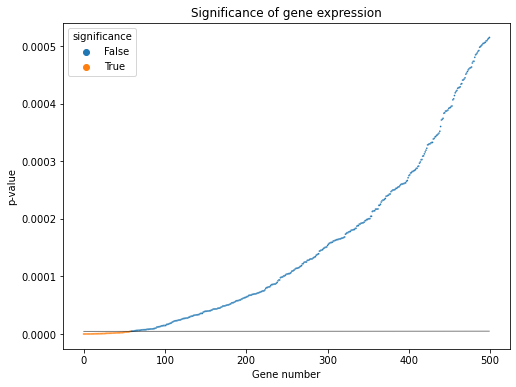

In [305]:
#print(results)
def plot_significance(results, threshold):
    results['number'] = range(len(results))
    #results['number'] = results.index
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x='number',y=threshold, data=results, ax=ax, color='black', linewidth=0.5)
    sns.scatterplot(x='number',y='p_value', hue='significance', data=results, s=3, ax=ax)
    ax.set_title('Significance of gene expression')
    ax.set_xlabel('Gene number')
    ax.set_ylabel('p-value')
    
plot_significance(holms_results.iloc[:500,:], 'holms_threshold')
#plot_significance(holms_results.iloc[:500,:], 'p_value')  

Notice the following about this plot:  
1. The p-value significance line crosses the threshold point at an apparent break point.   
2. The significant p-values are all very small since there are so many tests.

### Benamini-Hochberg FDR Control 

The Benamini-Hochberg FDR control algorithm is another way to control false discoveries. Stat with an ordered set of $n$ p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$ we define a false discovery rate, $q$:

$$FDR(D) \le q$$

The cutoff threshold for the ith p-value is then:
$$p_{(i)} \le Threshold(D_q) = \frac{q}{n} i$$

> **Exercise 01-9:** In this exercise you will apply the Benamini-Hochberg FDR control algorithm for testing the significance of the gene expressions. The `BH_significance` function is quite similar to the Holm's method function you have already created. Given the large number of genes you must use a low false discovery rate, $0.001$, or 1 out of 1,000. 
> Execute your function, saving the result. Then print the number of significant cases. 

In [306]:
def BH_significance(test_results, false_discovery_tollerance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
# Let's clean this up

    ## Declare vars
    num_rows_arr = []
    bh_sig =[]
    isit_sig = []
    order_i_num = []
    q = false_discovery_tollerance
    nrows = len(test_results)  # for index
    num_rws = range(1,nrows+1,1)
    bh_sig = []
    
    # create index array/ easy to manip df
    #for n in num_rws:ghost
    #    num_rows_arr.append(n)		ghost

    df_temp = test_results.copy()
    # order original p_values from smallest to Largest
    df_temp.sort_values('p_value', axis=0, ascending = True).reset_index(drop=True)

    #df_temp.loc[:,'row_num1']= num_rows_arr  ghost	

    # recall B-H equation: p(i) <= 	Threshold(D-subq) = (q * i) / n
    #                               where FDR(D) <= q	
    #                               D = { p(1), p(2),..p(n)}
    #                               q : false Discover Rate
    for irow in range(nrows):       # this actually should correspond to index of ord pval
        denom = nrows
        numer = q * irow
        the_bh = np.divide(numer,denom)         # This is the eqn
        thepval = df_temp.iloc[irow,2]          # This pulls the orig pval: checked col 'p_value' 
                                                #    corresponds to this col # 2
        bh_sig.append(the_bh)                   # This creates the bh thresh
        order_i_num.append(irow)
        if thepval <= the_bh:                   # Ongoing determines significance
            isit_sig.append(True)
        else:
            isit_sig.append(False)
    #df_temp.drop('row_num1', inplace=True, axis=1)
    #df_temp.drop('row_num1', inplace=True, axis=1)
    df_temp.loc[:,'bh_threshold']= bh_sig       # creates columns in df_temp
    df_temp.loc[:,'significance']= isit_sig     # ditto

    # Now to traverse the DataFrame from the bottom up leaving all in place
    for find_max_sig_ind in range(nrows-1,-1,-1):
        if df_temp['significance'][find_max_sig_ind]== True:
            max_index = find_max_sig_ind        # Flags where the max Significant pvalue is
            break                               # that's all the info we want here
 
    for bottomup_ind in range(max_index,nrows-1, -1):
        #df_temp.loc[:,'significance'] == True
        df_temp['significance'][bottomup]= True
 
    #df_temp.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)
    #df_temp.loc[:,'row_num1']= num_rows_arr
    #df_temp.loc[:,'i'] = order_i_num
     
    return df_temp
#BH_results = BH_significance(gene_statistics, 0.001)
BH_results = BH_significance(gene_statistics, 0.0001)  
print(str(len(BH_results)))
len(BH_results.loc[BH_results.loc[:,'significance'],:])

10497


2

> The result is similar to the first two FDR control methods. Given the false discovery parameter of 0.0001 do you think this is a reasonable result? 

Yes. There are 164 discoveries from the BH test. The False Discovery Rate of 0.0001  shows the expected number of false positives. We want the probability of Type I false positives to be less than
0.05 or 5%. this is possibility of 164/10497 = 0.0156235114794703. Which is acceptable.

Finally, execute the code in the cell below and examine the resulting plot.

<ipython-input-170-726dbee05f05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['number'] = range(len(results))


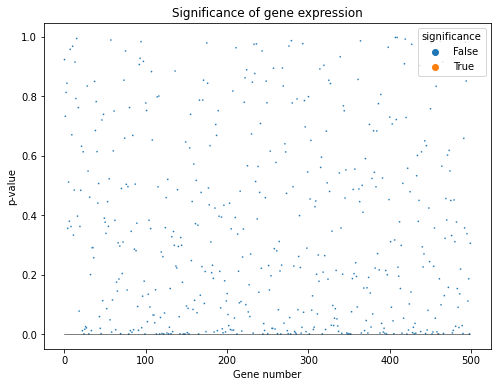

In [191]:
BH_results.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)
plot_significance(BH_results.iloc[:500,:], 'bh_threshold')  


> **Exercise 01-10**: Bonus question. Compare the plot above to the foregoing plot for Holm's method. Are the breaks in slope of the p-value curve at the crossing point with the threshold values reasonable in both cases? 

##### Copyright 2021, Stephen F. Elston. All rights reserved. 